# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200318/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200319/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200324/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200325/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200326/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200330/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200416/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200422/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200427/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200501/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'

plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/2016/'

os.system("mkdir -p "+ plotDir)

0

# ALL BKG TAG EFF

In [3]:
tags = []
tags = [
    
        'H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
        'QCD_HT_all, background',
        'WLNu_HT_all, background',
        'ZNunu_HT_all, background',
        'TT_Lep, background',

        'Data 2016',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

fnames['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v4/MC_Summer16/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['QCD_HT_all, background'] = 'V1p17/v4/MC_Summer16/normalized/QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['WLNu_HT_all, background'] = 'V1p17/v4/MC_Summer16/normalized/WJetsToLNu_HT-70ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['ZNunu_HT_all, background'] = 'V1p17/v4/MC_Summer16/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['TT_Lep, background'] = 'V1p17/v4/MC_Summer16/normalized/TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['Data 2016'] = 'V1p17/v5/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_GoodLumi.root'
# fnames['Data 2016'] = 'V1p17/v5/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17.root'
# fnames['Data 2016'] = 'V1p17/v4/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17.root'


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v4/MC_Summer16/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb), 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7fa60c40a0b8> OrderedDict([('H(bb)H(bb), 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7fa60c40a0b8>)])
[[0.3811219 0.043495677 0.05918682 0.4142442] [0.014636423] [0.38804093 0.27342394 0.0 0.02618078 0.031228911 0.5336337] ... [0.0 0.4056679] [0.7810731 0.0 0.54346925] [0.016146922 0.115063936]]
[8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06
 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06]
[8.41607e-06]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v4/MC_Summer16/normalized/QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root
Open ready
QCD_HT_all, background
Tree ready
<TTree b'SusyLLPTree' at 0x7fa60c1f0668> OrderedDict([('H(bb)H(bb), 200 GeV, 1 GeV, 1 m', <T

# Test/Debug Plot

In [5]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
#     flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
    if 'background' in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
    if 'background' in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
        

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
    if 'background' in k:
        trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa60c40a0b8>
(3511,)
3008
3008
QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fa60c1f0668>
(380887,)
262945
262945
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7fa5fdcf40f0>
(7823141,)
3255459
3255459
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fa5fdadc208>
(8214308,)
7872020
7872020
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fa4db338fd0>
(17035164,)
6314802
6314802
Data 2016 <TTree b'SusyLLPTree' at 0x7fa4daa0eac8>
(2390101,)
1526967
1526967


In [6]:
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_no_jet_req/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1pho_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5_invert/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
 
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
    
print(plotDir)
os.system("mkdir -p "+ plotDir)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/


0

In [7]:
variables = [
 
    
        ['minDeltaPhi', trg_jet_mdphi, 50, 0, 3.15],
        ['HT', trg_jet_ht, 40, 0, 2000],
        ['MET', trg_jet_met, 20, 0, 2000],
        ['nJets', trg_jet_nj, 20, 0, 20],
    
#         ['nMuons', trg_jet_nmu, 20, 0, 20],
#         ['nElectrons', trg_jet_nele, 20, 0, 20],
#         ['nPhotons', trg_jet_npho, 20, 0, 20],
#         ['nTaus', trg_jet_ntau, 20, 0, 20],
#         ['MT', trg_jet_mt, 50, 0, 1000],
    
    
#         ['nBJets', trg_jet_nb, 20, 0, 20],
    
]

var/x_axis minDeltaPhi binning 50 0 3.15
QCD_HT_all, background 262945
WLNu_HT_all, background 3255459
TT_Lep, background 6314802
ZNunu_HT_all, background 7872020
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.009308510173548619
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
Data 2016 1
total 0.0 0.0
35.9 fb^{-1} (13 TeV)
var/x_axis HT binning 40 0 2000
QCD_HT_all, background 262945
WLNu_HT_all, background 3255459
TT_Lep, background 6314802
ZNunu_HT_all, background 7872020
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 1.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
Data 2016 1
total 4.4695119157549925 1.324565677313086
35.9 fb^{-1} (13 TeV)
var/x_axis MET binning 20 0 2000
QCD_HT_all, background 262945
WLNu_HT_all, background 3255459
TT_Lep, background 6314802
ZNunu_HT_all, background 7872020
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 1.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
Data 2016 1
total 0.0 0.0
35.

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: QCD_HT_all, background (50, 0.000000, 3.150000)
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: WLNu_HT_all, background (50, 0.000000, 3.150000)
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: TT_Lep, b

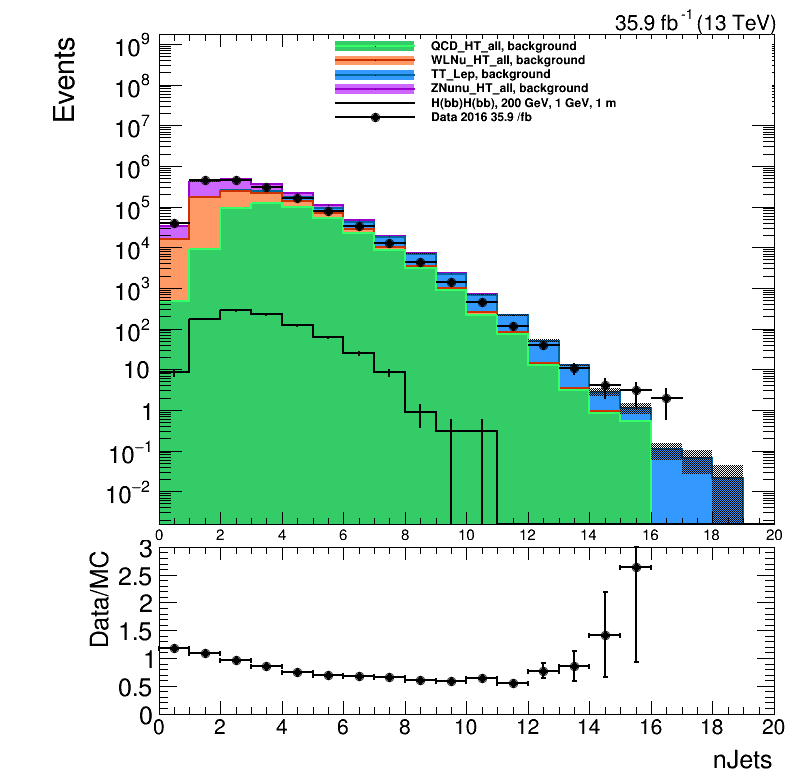

In [8]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 35900 
#     outf = var[0]+'_stack.png'
    
    # Plotting THStack
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
    pad1.SetBottomMargin(0.03)
    # pad1.SetGridx()
    pad1.SetLogy()
    pad1.SetLeftMargin(0.2)
    pad1.SetRightMargin(0.027)
    pad1.Draw()
    pad1.cd()
    
    stack = rt.THStack( "hs" , "H Stack " )
    total = rt.TH1D('total','total',3,0,3)
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
    keys = ['QCD_HT_all, background', 'WLNu_HT_all, background',  'TT_Lep, background', 'ZNunu_HT_all, background',]
#     keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#     sig_keys = []
    sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
    data_keys = ['Data 2016']
    # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
    bkg_integral = 0.0
    max_value = 0
    i=0
    for k in keys:
        if 'background' in k or True:


            pt1 = var[1][k] 
            v = pt1 
            w = trg_jet_w[k] 
            pu = trg_jet_puw[k] 
            if 'QCD' in k:
                sf=1.1
                outf = var[0]+'_stack_sf_'+str(sf).replace('.','p')+'.png'   
            else:
                sf=1
            print(k,len(v))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*pu*lumi*sf)
            ht[k].Sumw2()
            total.Add(ht[k])
            stack.Add( ht[k])
            ht[k].SetLineColor(color_list[i]+3)
            ht[k].SetFillColor(color_list[i])
            leg.AddEntry(ht[k],k)
            max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
            bkg_integral += ht[k].Integral()

            i+=1
    stack.Draw('hist')
    # stack.SetMaximum(max_value*1.5)
    stack.SetMaximum(max_value*1e+03)
    stack.SetMinimum(10e-3)
    stack.GetYaxis().SetTitle(y_axis)
    stack.GetXaxis().SetTitle(x_axis)
    stack.GetXaxis().SetLabelSize(0.03)



    i=0
    for k in sig_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_jet_w[k] 

        factor = bkg_integral/np.sum(w)
        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)
        max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

        i+=1

    i=0
    for k in data_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_jet_w[k] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        ht[k].SetMarkerColor(std_color_list[i])
        ht[k].SetMarkerStyle(20)
        ht[k].SetMarkerSize(1.)
        print(k, std_color_list[i])
        ht[k].Draw("p E same")
        leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

        i+=1

    leg.Draw()

    last = stack.GetStack().Last()
    total.SetFillStyle(3001)
    total.SetLineColor(1)
    total.SetFillColor(1)

    total.GetYaxis().SetTitleOffset(1.6)
    total.Draw("same e2")
    print("total",total.GetBinContent(1),total.GetBinError(1))
    
    c.cd()
    pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.03)
    pad2.SetBottomMargin(0.25)
    # pad2.SetGrid()
    pad2.SetLeftMargin(0.2)
    pad2.SetRightMargin(0.027)
    pad2.Draw()
    pad2.cd()

    h_copy = ht['Data 2016'].Clone()
    h_copy.Divide(stack.GetStack().Last())
    h_copy.GetYaxis().SetTitleOffset(0.4)
#     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
    h_copy.GetYaxis().SetTitleSize(0.12)
    h_copy.GetYaxis().SetLabelSize(0.12)
    h_copy.GetYaxis().SetNdivisions(506)
    h_copy.SetMaximum(3)
#     h_copy.SetMaximum(1)
#     h_copy.SetMaximum(0.5)
#     h_copy.SetMinimum(-1)
    h_copy.SetMinimum(0)



    h_copy.GetXaxis().SetTitleOffset(1)
    h_copy.GetXaxis().SetTitleSize(0.12)
    h_copy.GetXaxis().SetLabelSize(0.10)
    h_copy.GetXaxis().SetTickSize(0.07)
    h_copy.SetYTitle('Data/MC')
    h_copy.SetTitle("")
#        h.SetStats(0)
    h_copy.DrawCopy('E1')
    pad2.Update()
    
    


#     c = make_ratio_plot([total,ht['Data 2016']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])


    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

In [74]:
# for var in variables:
#     print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
#     x_axis = var[0]
#     y_axis = 'Events'
#     axis_set = [x_axis, y_axis]
#     bin_set = [var[2],var[3],var[4]]
#     lumi = 35900 
#     outf = var[0]+'_shape.png'
    
#     # Plotting THStack
#     c = rt.TCanvas('c','c', 800, 800)
#     ht = {}
#     # leg = rt.TLegend(0.59,0.70,0.97,0.93)
#     leg = rt.TLegend(0.40,0.78,0.97,0.94)

#     leg.SetTextSize(0.025)
#     leg.SetBorderSize(0)
#     leg.SetEntrySeparation(0.01)
#     stack = rt.THStack( "hs" , "H Stack " )
#     total = rt.TH1D('total','total',3,0,3)
#     color_list = [845,800,861,806,876,597,625]
#     keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#     sig_keys = []
# #     sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m' ]
#     data_keys = ['Data 2016']
#     # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
#     bkg_integral = 0.0
#     max_value = 0
#     i=0
#     for k in keys:
#         if 'background' in k or True:


#             pt1 = var[1][k] 
#             v = pt1 
#             w = trg_jet_w[k] 
#             print(k,len(v))
#             ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
#             ht[k].SetLineColor(color_list[i])
#             ht[k].SetMinimum(1e-3)
#             ht[k].SetMaximum(1e+3*(ht[k].GetMaximum()))
#             ht[k].GetXaxis().SetLabelSize(0.02)
#             ht[k].GetYaxis().SetLabelSize(0.03)
#             ht[k].DrawNormalized('histsame')
#             leg.AddEntry(ht[k],k)
            
#             i+=1
   
#     leg.Draw()




#     CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
#     CMS_lumi.cmsText = ""
#     CMS_lumi.writeExtraText = False
#     CMS_lumi.CMS_lumi(c,4,3)


#     c.SetLeftMargin(0.2)
#     c.SetRightMargin(0.027)
#     c.SetLogy()
#     c.Draw()
#     c.SaveAs(plotDir+outf)
 

In [75]:
# trg_path=310
# njet_cut=-1
# met_cut=200
# veto=1

# # jet_eta_cut=2.4
# jet_eta_cut=1.48
# jet_pt_cut=30
# jet_time_cut=-1


# # trg_jet_met = {}
# # trg_jet_nj = {}
# # trg_jet_mt = {}
# # trg_jet_ht = {}
# # trg_jet_mdphi = {}
# trg_jet_w = {} 

# trg_jet_pt = {}
# # trg_jet_eta = {}
# # trg_jet_e = {}
# # trg_jet_phi = {}

# # trg_jet_chef = {}
# # trg_jet_muef = {}
# # trg_jet_eleef = {}
# trg_jet_phoef = {}

# # trg_jet_nhef = {}
# # trg_jet_cemef = {}
# # trg_jet_nemef = {}

# # trg_jet_tmf = {}
# # trg_jet_dr = {}
# # trg_jet_time = {}


# for k,v in tree.items():
#     print(k,v)

#     # branches
#     met = v['met'].array()
# #     mt = v['MT_'].array()
#     ht = v['HT'].array()
# #     mdphi = v['jetMet_dPhi'].array()
#     mdphi = v['jetMet_dPhiMin'].array()
#     hlt = v['HLTDecision'].array()[:,trg_path]
#     nj = v['nJets'].array()
#     nlep = v['nLeptons'].array()
#     nmu = v['nMuons'].array()
#     nele = v['nElectrons'].array()
#     ntau = v['nTaus'].array()
#     npho = v['nPhotons'].array()
    
#     pho_eta = v['phoEta'].array()
#     pho_phi = v['phoPhi'].array()
    
#     #flags
#     flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
# #     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
# #     flag3 =  v['Flag2_goodVertices'].array()
# #     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
#     flag5 =  v['Flag2_BadPFMuonFilter'].array() 
#     flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
#     flag7 =  v['Flag2_HBHENoiseFilter'].array() 
#     flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
# #     flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
#     flag10 =  v['Flag2_eeBadScFilter'].array() 
    
#     #jet var
#     pt = v['jetPt'].array()
#     eta = v['jetEta'].array()
#     e = v['jetE'].array()
#     phi = v['jetPhi'].array()
    
#     chef = v['jetChargedHadronEnergyFraction'].array()
#     muef = v['jetMuonEnergyFraction'].array()
#     eleef = v['jetElectronEnergyFraction'].array()
#     phoef = v['jetPhotonEnergyFraction'].array()
    
# #     nhef = v['jetNeutralHadronEnergyFraction'].array()
# #     cemef = v['jetNeutralEMEnergyFraction'].array()
# #     nemef = v['jetNeutralEMEnergyFraction'].array()
 
#     tmf = v['jetGammaMax_ET'].array()
#     dr = v['jetMinDeltaRPVTracks'].array()
#     time = v['jetTime'].array()

#     weight = v['weight'].array()
    
#     print(weight.shape)
    
#     #selection
    
#     sel_hlt_triggered = 1
#     sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
#     sel_flag_str = np.logical_and(flag1, flag5)
#     sel_flag_str = np.logical_and(sel_flag_str, flag6)
#     sel_flag_str = np.logical_and(sel_flag_str, flag7)
#     sel_flag_str = np.logical_and(sel_flag_str, flag8)
#     if 'Data' in k:
#         sel_flag_str = np.logical_and(sel_flag_str, flag10)

#     basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
#     basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
#     basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
#     if veto==1:
#         basic_met_str = np.logical_and(basic_met_str, nmu==0)
#         basic_met_str = np.logical_and(basic_met_str, nele==0)
#         basic_met_str = np.logical_and(basic_met_str, ntau==0)
#         basic_met_str = np.logical_and(basic_met_str, npho==1)
# #         basic_met_str = np.logical_and(basic_met_str, npho==0)
    
#     basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
#     basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   

#     met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
#     met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
    
# #   sel 
# #     trg_jet_met[k] = met
# #     trg_jet_nj[k] = nj 
# #     trg_jet_w[k] = weight 
# # #     trg_jet_mt[k] = mt
# #     trg_jet_ht[k] = ht
# #     trg_jet_mdphi[k] = mdphi
    
# #     trg_jet_pt[k] = pt
# #     trg_jet_eta[k] = eta
# #     trg_jet_e[k] = e
# #     trg_jet_phi[k] = phi
# #     trg_jet_chef[k] = chef
# #     trg_jet_nhef[k] = nhef
# #     trg_jet_cemef[k] = cemef
# #     trg_jet_nemef[k] = nemef
    
#     #apply sel
# #     trg_jet_met[k] = met[met_trg_str]
# #     trg_jet_ht[k] = ht[met_trg_str]
# #     trg_jet_mdphi[k] = mdphi[met_trg_str]
# #     trg_jet_nj[k] = nj[met_trg_str]
#     trg_jet_w[k] = weight[met_trg_str]

#     trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
# #     trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
# #     trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
# #     trg_jet_e[k] = e[basic_jet_str][met_trg_str]

# #     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
# #     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
# #     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
# #     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
# #     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
# #     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
# #     trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
# #     trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
# #     trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
#     trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
# #     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
# #     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
# #     trg_jet_time[k] = time[basic_jet_str][met_trg_str]
# #     trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
# #     trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
# #     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

#     #clean up
# #     trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

# #     trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

# #     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
# #     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
# #     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
# #     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
# #     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

#     #print out check


#     print(len(trg_jet_w[k]))
#     print(len(trg_jet_pt[k]))

    

In [9]:
variables = [
#         ['jetNeutralHadronMultiplicity', trg_jet_nhm, 20, -0.5, 19.5],
#         ['jetChargedHadronMultiplicity', trg_jet_chm, 50, -0.5, 49.5],
#         ['jetMuonMultiplicity', trg_jet_mum, 20, -0.5, 19.5],
#         ['jetElectronMultiplicity', trg_jet_elem, 20, -0.5, 19.5],
#         ['jetPhotonMultiplicity', trg_jet_phom, 50, -0.5, 49.5],
    
#         ['jetNeutralHadronEnergyFraction', trg_jet_nhef, 50, 0, 1],
#         ['jetChargedHadronEnergyFraction', trg_jet_chef, 50, 0, 1],
#         ['jetChargedEMEnergyFraction', trg_jet_cemef, 50, 0, 1],
#         ['jetNeutralEMEnergyFraction', trg_jet_nemef, 50, 0, 1],
   
#         ['jetEcalEnergy', trg_jet_ecale, 50, 0, 2500],
#         ['jetHcalEnergy', trg_jet_hcale, 50, 0, 2500],
    
#         ['jetCSV', trg_jet_csv, 50, 0, 1],
    
#         ['jetPt', trg_jet_pt, 10, 0, 100],
#         ['jetPt', trg_jet_pt, 50, 0, 1000],
    
#         ['jetChargedHadronEnergyFraction', trg_jet_chef, 50, 0, 0.1],
    
        ['jetTime', trg_jet_time, 50, -13, 13],
        ['jetMinDeltaRPVTracks', trg_jet_dr, 50, 0, 3],
        ['jetTMF', trg_jet_tmf, 50, 0, 1],
    
    
        ['jetPt', trg_jet_pt, 20, 0, 2000],
        ['jetEta', trg_jet_eta, 20, -3.15, 3.15],
        ['jetE', trg_jet_e, 50, 0, 1000],
        ['jetPhi', trg_jet_phi, 20, -3.15, 3.15],
    
     
        ['jetMuonEnergyFraction', trg_jet_muef, 50, 0, 1],
        ['jetElectronEnergyFraction', trg_jet_eleef, 50, 0, 1],
        ['jetPhotonEnergyFraction', trg_jet_phoef, 50, 0, 1],
    
        ['jetChargedHadronEnergyFraction', trg_jet_chef, 50, 0, 1],
    
        ['jetCSV', trg_jet_csv, 50, 0, 1],
 
    
]

In [77]:
 
# # plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep/'   
# # plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_no_jet_req/'   
# # plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig/'   
# # plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb/'   
# # plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1/debug/'   
 
# print(plotDir)
# os.system("mkdir -p "+ plotDir)

0
var/x_axis jetTime binning 50 -13 13
260078
QCD_HT_all, background 260078 260078
3003761
WLNu_HT_all, background 3003761 3003761
7051572
ZNunu_HT_all, background 7051572 7051572
6101093
TT_Lep, background 6101093 6101093
2689
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
1251560
Data 2016 1
total 0.0 0.0
35.9 fb^{-1} (13 TeV)
var/x_axis jetMinDeltaRPVTracks binning 50 0 3
260078
QCD_HT_all, background 260078 260078
3003761
WLNu_HT_all, background 3003761 3003761
7051572
ZNunu_HT_all, background 7051572 7051572
6101093
TT_Lep, background 6101093 6101093
2689
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 0 0.0
1251560
Data 2016 1
total 0.0 0.0
35.9 fb^{-1} (13 TeV)
var/x_axis jetTMF binning 50 0 1
260078
QCD_HT_all, background 260078 260078
3003761
WLNu_HT_all, background 3003761 3003761
7051572
ZNunu_HT_all, background 7051572 7051572
6101093
TT_L

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: QCD_HT_all, background (50, -13.000000, 13.000000)
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: 

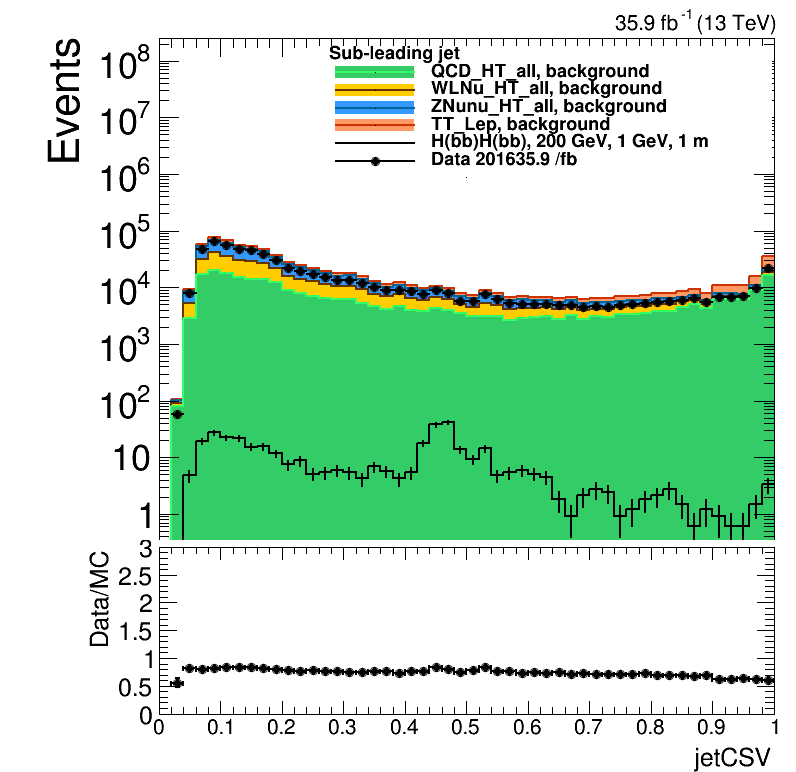

In [10]:
for cnt in range(2):
    print(cnt)
    part = cnt
    if cnt==0:
        cnt_str = 'Leading jet'
        name_str = 'leading_jet'
    else:
        cnt_str = 'Sub-leading jet'
        name_str = 'sub_leading_jet'
    for var in variables:
        print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
        x_axis = var[0]
        y_axis = 'Events'
        axis_set = [x_axis, y_axis]
        bin_set = [var[2],var[3],var[4]]
        lumi = 35900 
        outf = var[0]+'_'+name_str+'_stack_pt100.png'
#         outf = var[0]+'_'+name_str+'_stack.png'

        # Plotting THStack
        c = rt.TCanvas('c','c', 800, 800)
        ht = {}
        # leg = rt.TLegend(0.59,0.70,0.97,0.93)
        leg = rt.TLegend(0.40,0.78,0.97,0.94)

        leg.SetTextSize(0.025)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
    
#         pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
#         pad1.SetBottomMargin(0.03)
#         # pad1.SetGridx()
#         pad1.SetLogy()
#         pad1.SetLeftMargin(0.2)
#         pad1.SetRightMargin(0.027)
#         pad1.Draw()
#         pad1.cd()
    
        stack = rt.THStack( "hs" , "H Stack " )
        total = rt.TH1D('total','total',3,0,3)
        color_list = [845,800,861,806,876,597,625]
        keys=[]
        keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
        sig_keys = [  ]
        sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
#         data_keys = []
        data_keys = ['Data 2016']
        # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
        bkg_integral = 0.0
        max_value = 0
        i=0
        for k in keys:
            if 'background' in k or True:


                pt1 = var[1][k] 
                pt2 = pt1[pt1.count()>part]
                print(len(pt2))
                v = pt2[:,part]
                w = trg_jet_w[k][pt1.count()>part] 
                pu = trg_jet_puw[k][pt1.count()>part]  
                print(k,len(v),len(w))
                if 'QCD' in k:
                    sf=1.1
                else:
                    sf=1
                ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*pu*lumi*sf)
                ht[k].Sumw2()
                total.Add(ht[k])
                stack.Add( ht[k])
                ht[k].SetLineColor(color_list[i]+3)
                ht[k].SetFillColor(color_list[i])
                leg.AddEntry(ht[k],k)
                max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
                bkg_integral += ht[k].Integral()

                i+=1
        stack.Draw('hist')
        # stack.SetMaximum(max_value*1.5)
        stack.SetMaximum(max_value*1e+03)
        stack.SetMinimum(10e-3)
        stack.GetYaxis().SetTitle(y_axis)
        stack.GetXaxis().SetTitle(x_axis)
        stack.GetXaxis().SetLabelSize(0.03)



        i=0
        for k in sig_keys:
            pt1 = var[1][k] 
            pt2 = pt1[pt1.count()>part]
            print(len(pt2))
            v = pt2[:,part]
            w = trg_jet_w[k][pt1.count()>part] 

            factor = bkg_integral/np.sum(w)
            print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            print(k, std_color_list[i])
            ht[k].Draw("hist E same")
            leg.AddEntry(ht[k],k)
            max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
            print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

            i+=1

        i=0
        for k in data_keys:
            pt1 = var[1][k] 
            pt2 = pt1[pt1.count()>part]
            print(len(pt2))
            v = pt2[:,part]
            w = trg_jet_w[k][pt1.count()>part] 

            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            ht[k].SetMarkerColor(std_color_list[i])
            ht[k].SetMarkerStyle(20)
            ht[k].SetMarkerSize(1.)
            print(k, std_color_list[i])
            ht[k].Draw("p E same")
            leg.AddEntry(ht[k],k+str(lumi/1000)+' /fb')

            i+=1

        leg.SetHeader(cnt_str)
        leg.Draw()

        last = stack.GetStack().Last()
        total.SetFillStyle(3001)
        total.SetLineColor(1)
        total.SetFillColor(1)

        total.GetYaxis().SetTitleOffset(1.6)
        total.Draw("same e2")
        print("total",total.GetBinContent(1),total.GetBinError(1))

        c.cd()
        pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
        pad2.SetTopMargin(0.03)
        pad2.SetBottomMargin(0.25)
        # pad2.SetGrid()
        pad2.SetLeftMargin(0.2)
        pad2.SetRightMargin(0.027)
        pad2.Draw()
        pad2.cd()

        h_copy = ht['Data 2016'].Clone()
        h_copy.Divide(stack.GetStack().Last())
        h_copy.GetYaxis().SetTitleOffset(0.4)
    #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
        h_copy.GetYaxis().SetTitleSize(0.12)
        h_copy.GetYaxis().SetLabelSize(0.12)
        h_copy.GetYaxis().SetNdivisions(506)
        h_copy.SetMaximum(3)
        h_copy.SetMinimum(0)



        h_copy.GetXaxis().SetTitleOffset(1)
        h_copy.GetXaxis().SetTitleSize(0.12)
        h_copy.GetXaxis().SetLabelSize(0.10)
        h_copy.GetXaxis().SetTickSize(0.07)
        h_copy.SetYTitle('Data/MC')
        h_copy.SetTitle("")
    #        h.SetStats(0)
        h_copy.DrawCopy('E1')
        pad2.Update()
    



        CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
        CMS_lumi.cmsText = ""
        CMS_lumi.writeExtraText = False
        CMS_lumi.CMS_lumi(c,4,3)


        c.SetLeftMargin(0.2)
        c.SetRightMargin(0.027)
        c.SetLogy()
        c.Draw()
        c.SaveAs(plotDir+outf)


In [69]:
# for cnt in range(2):
#     print(cnt)
#     part = cnt
#     if cnt==0:
#         cnt_str = 'Leading jet'
#         name_str = 'leading_jet'
#     else:
#         cnt_str = 'Sub-leading jet'
#         name_str = 'sub_leading_jet'
#     for var in variables:
#         print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
#         x_axis = var[0]
#         y_axis = 'Events'
#         axis_set = [x_axis, y_axis]
#         bin_set = [var[2],var[3],var[4]]
#         lumi = 20000 
#         outf = var[0]+'_'+name_str+'_shape.png'

#         # Plotting THStack
#         c = rt.TCanvas('c','c', 800, 800)
#         ht = {}
#         # leg = rt.TLegend(0.59,0.70,0.97,0.93)
#         leg = rt.TLegend(0.40,0.78,0.97,0.94)

#         leg.SetTextSize(0.025)
#         leg.SetBorderSize(0)
#         leg.SetEntrySeparation(0.01)
        
    
    
#         stack = rt.THStack( "hs" , "H Stack " )
#         total = rt.TH1D('total','total',3,0,3)
#         color_list = [845,800,861,806,876,597,625]
#         keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#         sig_keys = [  ]
# #         sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m' ]
#         data_keys = ['Data 2016']
#         # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
#         bkg_integral = 0.0
#         max_value = 0
#         i=0
#         for k in keys:
#             if 'background' in k or True:


#                 pt1 = var[1][k] 
#                 pt2 = pt1[pt1.count()>part]
#                 print(len(pt2))
#                 v = pt2[:,part]
#                 w = trg_jet_w[k][pt1.count()>part] 
#                 print(k,len(v),len(w))
#                 ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
#                 ht[k].SetLineColor(color_list[i])
#                 ht[k].SetMinimum(1e-3)
#                 ht[k].SetMaximum(1e+3*(ht[k].GetMaximum()))
#                 ht[k].GetXaxis().SetLabelSize(0.02)
#                 ht[k].GetYaxis().SetLabelSize(0.03)
#                 ht[k].DrawNormalized('histsame')              
#                 leg.AddEntry(ht[k],k)
                

#                 i+=1
     

#         leg.Draw()

 



#         CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
#         CMS_lumi.cmsText = ""
#         CMS_lumi.writeExtraText = False
#         CMS_lumi.CMS_lumi(c,4,3)


#         c.SetLeftMargin(0.2)
#         c.SetRightMargin(0.027)
#         c.SetLogy()
#         c.Draw()
#         c.SaveAs(plotDir+outf)


# Tags

In [11]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa60c40a0b8>
[[116.09921 35.933475] [252.15971] [300.99045 72.4912 62.92249 38.417904 32.985218] ... [368.67926] [270.20718 30.76258] [138.20229 56.830166]]
[[] [252.15971] [72.4912] ... [] [] []]
[[116.09921 35.933475] [] [300.99045 62.92249 38.417904 32.985218] ... [368.67926] [270.20718 30.76258] [138.20229 56.830166]]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3]
[0 1 2]
QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fa60c1f0668>
[[593.0364 249.53702 36.278683] [565.5163] [569.83136 280.0468] ... [541.42993 462.4637 333.806] [164.15138] [323.10757 251.21028]]
[[] [] [] ... [] [] []]
[[593.0364 249.53702 36.278683] [565.5163] [569.83136 280.0468] ... [541.42993 462.4637 333.806] [164.15138] [323.10757 251.21028]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0 1]
[0 1]
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7fa5fdcf40f0>
[[] [] [111.41341 68.699135] ... [177.22496] [187.65535] []]
[[] [] [] ... [] [] []]
[[] [] [111.413

In [12]:
variables = [
 
        ['nTags', nTags, 3, 0, 3],
    
]

var/x_axis nTags binning 3 0 3
QCD_HT_all, background 262945
WLNu_HT_all, background 3255459
TT_Lep, background 6314802
ZNunu_HT_all, background 7872020
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 137 0.0011530016
Data 2016 1
total 1665748.6252248632 2397.8805296268797
35.9 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: Data 20

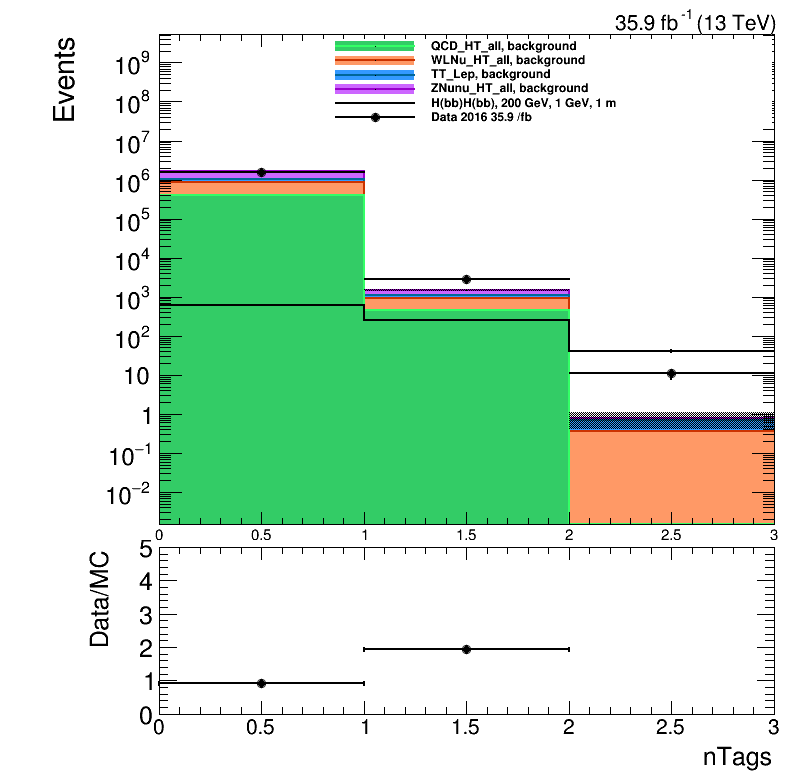

In [13]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 35900 
#     outf = var[0]+'_stack.png'
    
    # Plotting THStack
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
    pad1.SetBottomMargin(0.03)
    # pad1.SetGridx()
    pad1.SetLogy()
    pad1.SetLeftMargin(0.2)
    pad1.SetRightMargin(0.027)
    pad1.Draw()
    pad1.cd()
    
    stack = rt.THStack( "hs" , "H Stack " )
    total = rt.TH1D('total','total',3,0,3)
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
    keys = ['QCD_HT_all, background', 'WLNu_HT_all, background',  'TT_Lep, background', 'ZNunu_HT_all, background',]
#     keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#     sig_keys = []
    sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
    data_keys = ['Data 2016']
    # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
    bkg_integral = 0.0
    max_value = 0
    i=0
    for k in keys:
        if 'background' in k or True:


            pt1 = var[1][k] 
            v = pt1 
            w = trg_jet_w[k] 
            pu = trg_jet_puw[k] 
            if 'QCD' in k:
                sf=1.1
                outf = var[0]+'_stack_sf_'+str(sf).replace('.','p')+'.png'   
            else:
                sf=1
            print(k,len(v))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*pu*lumi*sf)
            ht[k].Sumw2()
            total.Add(ht[k])
            stack.Add( ht[k])
            ht[k].SetLineColor(color_list[i]+3)
            ht[k].SetFillColor(color_list[i])
            leg.AddEntry(ht[k],k)
            max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
            bkg_integral += ht[k].Integral()

            i+=1
    stack.Draw('hist')
    # stack.SetMaximum(max_value*1.5)
    stack.SetMaximum(max_value*1e+03)
    stack.SetMinimum(10e-3)
    stack.GetYaxis().SetTitle(y_axis)
    stack.GetXaxis().SetTitle(x_axis)
    stack.GetXaxis().SetLabelSize(0.03)



    i=0
    for k in sig_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_jet_w[k] 

        factor = bkg_integral/np.sum(w)
        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)
        max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

        i+=1

    i=0
    for k in data_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_jet_w[k] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        ht[k].SetMarkerColor(std_color_list[i])
        ht[k].SetMarkerStyle(20)
        ht[k].SetMarkerSize(1.)
        print(k, std_color_list[i])
        ht[k].Draw("p E same")
        leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

        i+=1

    leg.Draw()

    last = stack.GetStack().Last()
    total.SetFillStyle(3001)
    total.SetLineColor(1)
    total.SetFillColor(1)

    total.GetYaxis().SetTitleOffset(1.6)
    total.Draw("same e2")
    print("total",total.GetBinContent(1),total.GetBinError(1))
    
    c.cd()
    pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.03)
    pad2.SetBottomMargin(0.25)
    # pad2.SetGrid()
    pad2.SetLeftMargin(0.2)
    pad2.SetRightMargin(0.027)
    pad2.Draw()
    pad2.cd()

    h_copy = ht['Data 2016'].Clone()
    h_copy.Divide(stack.GetStack().Last())
    h_copy.GetYaxis().SetTitleOffset(0.4)
#     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
    h_copy.GetYaxis().SetTitleSize(0.12)
    h_copy.GetYaxis().SetLabelSize(0.12)
    h_copy.GetYaxis().SetNdivisions(506)
    h_copy.SetMaximum(5)
#     h_copy.SetMaximum(3)
#     h_copy.SetMaximum(1)
#     h_copy.SetMaximum(0.5)
#     h_copy.SetMinimum(-1)
    h_copy.SetMinimum(0)



    h_copy.GetXaxis().SetTitleOffset(1)
    h_copy.GetXaxis().SetTitleSize(0.12)
    h_copy.GetXaxis().SetLabelSize(0.10)
    h_copy.GetXaxis().SetTickSize(0.07)
    h_copy.SetYTitle('Data/MC')
    h_copy.SetTitle("")
#        h.SetStats(0)
    h_copy.DrawCopy('E1')
    pad2.Update()
    
    


#     c = make_ratio_plot([total,ht['Data 2016']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])


    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

var/x_axis nTags binning 3 0 3
QCD_HT_all, background 262945
WLNu_HT_all, background 3255459
TT_Lep, background 6314802
ZNunu_HT_all, background 7872020
H(bb)H(bb), 200 GeV, 1 GeV, 1 m factor 0.0
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), 200 GeV, 1 GeV, 1 m 137 0.0011530016
Data 2016 1
total 1665748.6252248632 2397.8805296268797
35.9 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: Data 20

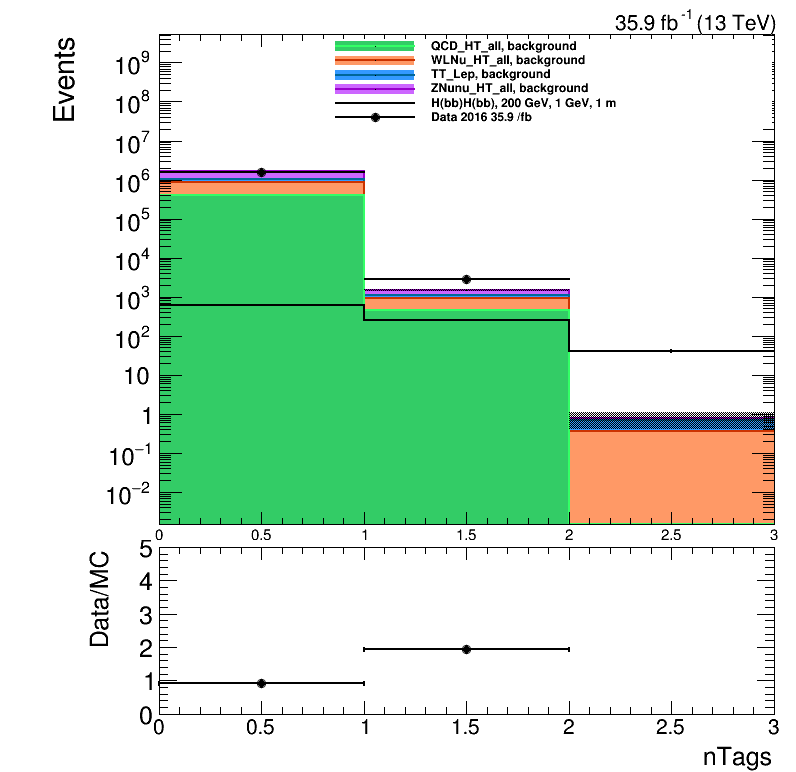

In [14]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    lumi = 35900 
#     outf = var[0]+'_stack.png'
    
    # Plotting THStack
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
    pad1.SetBottomMargin(0.03)
    # pad1.SetGridx()
    pad1.SetLogy()
    pad1.SetLeftMargin(0.2)
    pad1.SetRightMargin(0.027)
    pad1.Draw()
    pad1.cd()
    
    stack = rt.THStack( "hs" , "H Stack " )
    total = rt.TH1D('total','total',3,0,3)
    color_list = [845,806,861,876,597,625]
#     color_list = [845,800,861,806,876,597,625]
    keys = ['QCD_HT_all, background', 'WLNu_HT_all, background',  'TT_Lep, background', 'ZNunu_HT_all, background',]
#     keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#     sig_keys = []
    sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
    data_keys = ['Data 2016']
    # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
    bkg_integral = 0.0
    max_value = 0
    i=0
    for k in keys:
        if 'background' in k or True:


            pt1 = var[1][k] 
            v = pt1 
            w = trg_jet_w[k] 
            pu = trg_jet_puw[k] 
            if 'QCD' in k:
                sf=1.1
                outf = var[0]+'_stack_sf_'+str(sf).replace('.','p')+'_blind.png'   
            else:
                sf=1
            print(k,len(v))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*pu*lumi*sf)
            ht[k].Sumw2()
            total.Add(ht[k])
            stack.Add( ht[k])
            ht[k].SetLineColor(color_list[i]+3)
            ht[k].SetFillColor(color_list[i])
            leg.AddEntry(ht[k],k)
            max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
            bkg_integral += ht[k].Integral()

            i+=1
    stack.Draw('hist')
    # stack.SetMaximum(max_value*1.5)
    stack.SetMaximum(max_value*1e+03)
    stack.SetMinimum(10e-3)
    stack.GetYaxis().SetTitle(y_axis)
    stack.GetXaxis().SetTitle(x_axis)
    stack.GetXaxis().SetLabelSize(0.03)



    i=0
    for k in sig_keys:
        pt1 = var[1][k] 
        v = pt1 
        w = trg_jet_w[k] 

        factor = bkg_integral/np.sum(w)
        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)
        max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

        i+=1

    i=0
    for k in data_keys:
        pt1 = var[1][k] 
        for y,ele in enumerate(pt1):
            if ele==2:
                pt1[y]=3
        v = pt1 
        w = trg_jet_w[k] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
        ht[k].Sumw2()
        ht[k].SetLineColor(std_color_list[i])
        ht[k].SetMarkerColor(std_color_list[i])
        ht[k].SetMarkerStyle(20)
        ht[k].SetMarkerSize(1.)
        print(k, std_color_list[i])
        ht[k].Draw("p E same")
        leg.AddEntry(ht[k],k+' '+str(lumi/1000)+' /fb')

        i+=1

    leg.Draw()

    last = stack.GetStack().Last()
    total.SetFillStyle(3001)
    total.SetLineColor(1)
    total.SetFillColor(1)

    total.GetYaxis().SetTitleOffset(1.6)
    total.Draw("same e2")
    print("total",total.GetBinContent(1),total.GetBinError(1))
    
    c.cd()
    pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.03)
    pad2.SetBottomMargin(0.25)
    # pad2.SetGrid()
    pad2.SetLeftMargin(0.2)
    pad2.SetRightMargin(0.027)
    pad2.Draw()
    pad2.cd()

    h_copy = ht['Data 2016'].Clone()
    h_copy.Divide(stack.GetStack().Last())
    h_copy.GetYaxis().SetTitleOffset(0.4)
#     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
    h_copy.GetYaxis().SetTitleSize(0.12)
    h_copy.GetYaxis().SetLabelSize(0.12)
    h_copy.GetYaxis().SetNdivisions(506)
    h_copy.SetMaximum(5)
#     h_copy.SetMaximum(3)
#     h_copy.SetMaximum(1)
#     h_copy.SetMaximum(0.5)
#     h_copy.SetMinimum(-1)
    h_copy.SetMinimum(0)



    h_copy.GetXaxis().SetTitleOffset(1)
    h_copy.GetXaxis().SetTitleSize(0.12)
    h_copy.GetXaxis().SetLabelSize(0.10)
    h_copy.GetXaxis().SetTickSize(0.07)
    h_copy.SetYTitle('Data/MC')
    h_copy.SetTitle("")
#        h.SetStats(0)
    h_copy.DrawCopy('E1')
    pad2.Update()
    
    


#     c = make_ratio_plot([total,ht['Data 2016']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])


    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

# Tag Eff

In [57]:
from itertools import chain 

wall = {}
wnum = {}

pt_denall = {}
eta_denall = {}
pt_numall = {}
eta_numall = {}

pt_den_all = {}
eta_den_all = {}
pt_num_all = {}
eta_num_all = {}

pt_pEff = {}
eta_pEff = {}

for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    eta_denall[k] = np.array(trg_jet_eta[k].flatten())
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(eta_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    eta_numall[k] =  np.array(tag_jet_eta[k].flatten())
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
#     print(len(trg_jet_w[k]))
#     print(len(tag_jet_pt[k]))
    
    print(len(pt_numall[k]))
    print(len(eta_numall[k]))
#     print(max(eta_numall[k]))
#     print(min(eta_numall[k]))
#     print(eta_numall[k])
#     print(pt_numall[k])
    print(len(wnum[k]))
    
    #histogram
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wnum[k])
    
#     pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[10,-0,100], weights=wall[k])
#     pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[10,-0,100], weights=wnum[k])
    
    eta_den_all[k] = create_TH1D( eta_denall[k], axis_title=['jetEta ', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wall[k])
    eta_num_all[k] = create_TH1D( eta_numall[k], axis_title=['jetEta', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wnum[k])
  
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
    eta_pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
    

H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f3dbb1cde10>
5916
5916
5916
1194
1194
1194
QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7f3d788bba90>
851490
851490
851490
410
410
410
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7f3dc98d3ba8>


KeyboardInterrupt: 

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [ ]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.005],
#         ['jetEta', eta_pEff, 'eta', -0.0002, 0.005],
    
]

In [ ]:

   

color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(10):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


# Tag bins

In [ ]:
variables = [
 
        ['jetChargedHadronEnergyFraction', trg_jet_chef, 50, 0, 1],
 
        ['jetTime', trg_jet_time, 50, -13, 13],
        ['jetMinDeltaRPVTracks', trg_jet_dr, 50, 0, 3],
        ['jetTMF', trg_jet_tmf, 50, 0, 1],
    
    
#         ['jetPt', trg_jet_pt, 10, 0, 100],
        ['jetPt', trg_jet_pt, 20, 0, 2000],
        ['jetEta', trg_jet_eta, 20, -3.15, 3.15],
        ['jetE', trg_jet_e, 50, 0, 1000],
        ['jetPhi', trg_jet_phi, 20, -3.15, 3.15],
    
        ['jetMuonEnergyFraction', trg_jet_muef, 50, 0, 1],
        ['jetElectronEnergyFraction', trg_jet_eleef, 50, 0, 1],
        ['jetPhotonEnergyFraction', trg_jet_phoef, 50, 0, 1],
    
    
    
]

In [ ]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig/tags/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb/tags/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1/tags/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8/tags/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tags/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tags/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/tags/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1/tags/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tags/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5_invert/tags/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tags/'
print(plotDir)
os.system("mkdir -p "+ plotDir)

In [ ]:
for binN in range(3):
    bin_str = 'Bin'+str(binN)
    for cnt in range(2):
        print(cnt)
        part = cnt
        if cnt==0:
            cnt_str = 'Leading jet'
            name_str = 'leading_jet'
        else:
            cnt_str = 'Sub-leading jet'
            name_str = 'sub_leading_jet'
        for var in variables:
            print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
            x_axis = var[0]
            y_axis = 'Events'
            axis_set = [x_axis, y_axis]
            bin_set = [var[2],var[3],var[4]]
            lumi = 35900 
#             outf = bin_str+'_'+var[0]+'_'+name_str+'_stack_pt100.png'
            outf = bin_str+'_'+var[0]+'_'+name_str+'_stack.png'

            # Plotting THStack
            c = rt.TCanvas('c','c', 800, 800)
            ht = {}
            # leg = rt.TLegend(0.59,0.70,0.97,0.93)
            leg = rt.TLegend(0.40,0.78,0.97,0.94)

            leg.SetTextSize(0.025)
            leg.SetBorderSize(0)
            leg.SetEntrySeparation(0.01)


            pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
            pad1.SetBottomMargin(0.03)
            # pad1.SetGridx()
            pad1.SetLogy()
            pad1.SetLeftMargin(0.2)
            pad1.SetRightMargin(0.027)
            pad1.Draw()
            pad1.cd()

            stack = rt.THStack( "hs" , "H Stack " )
            total = rt.TH1D('total','total',3,0,3)
            color_list = [845,800,861,806,876,597,625]
            keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#             sig_keys = [  ]
            sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
            data_keys = ['Data 2016']
            # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
            bkg_integral = 0.0
            max_value = 0
            i=0
            for k in keys:
                if 'background' in k or True:


                    pt1 = var[1][k] 
                    sel_str = np.logical_and(pt1.count()>part, nTags[k]==binN)
                    pt2 = pt1[sel_str]
                    print(len(pt2))
                    v = pt2[:,part]
                    w = trg_jet_w[k][sel_str] 
                    pu = trg_jet_puw[k][sel_str] 
                    print(k,len(v),len(w))
                    if 'QCD' in k:
                        sf=1.1
                    else:
                        sf=1
                    ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*pu*lumi*sf)
                    ht[k].Sumw2()
                    total.Add(ht[k])
                    stack.Add( ht[k])
                    ht[k].SetLineColor(color_list[i]+3)
                    ht[k].SetFillColor(color_list[i])
                    leg.AddEntry(ht[k],k)
                    max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
                    bkg_integral += ht[k].Integral()

                    i+=1
            stack.Draw('hist')
            # stack.SetMaximum(max_value*1.5)
            stack.SetMaximum(max_value*1e+03)
            stack.SetMinimum(10e-3)
            stack.GetYaxis().SetTitle(y_axis)
            stack.GetXaxis().SetTitle(x_axis)
            stack.GetXaxis().SetLabelSize(0.03)



            i=0
            for k in sig_keys:
                pt1 = var[1][k] 
                sel_str = np.logical_and(pt1.count()>part, nTags[k]==binN)
                pt2 = pt1[sel_str]
                print(len(pt2))
                v = pt2[:,part]
                w = trg_jet_w[k][sel_str] 

                factor = bkg_integral/np.sum(w)
                print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
                ht[k].Sumw2()
                ht[k].SetLineColor(std_color_list[i])
                print(k, std_color_list[i])
                ht[k].Draw("hist E same")
                leg.AddEntry(ht[k],k)
                max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
                print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                i+=1

            i=0
            for k in data_keys:
                pt1 = var[1][k] 
                sel_str = np.logical_and(pt1.count()>part, nTags[k]==binN)
                pt2 = pt1[sel_str]
                print(len(pt2))
                v = pt2[:,part]
                w = trg_jet_w[k][sel_str] 

                ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
                ht[k].Sumw2()
                ht[k].SetLineColor(std_color_list[i])
                ht[k].SetMarkerColor(std_color_list[i])
                ht[k].SetMarkerStyle(20)
                ht[k].SetMarkerSize(1.)
                print(k, std_color_list[i])
                ht[k].Draw("p E same")
                leg.AddEntry(ht[k],k+str(lumi/1000)+' /fb')

                i+=1

            leg.SetHeader(cnt_str)
            leg.Draw()

            last = stack.GetStack().Last()
            total.SetFillStyle(3001)
            total.SetLineColor(1)
            total.SetFillColor(1)

            total.GetYaxis().SetTitleOffset(1.6)
            total.Draw("same e2")
            print("total",total.GetBinContent(1),total.GetBinError(1))

            c.cd()
            pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
            pad2.SetTopMargin(0.03)
            pad2.SetBottomMargin(0.25)
            # pad2.SetGrid()
            pad2.SetLeftMargin(0.2)
            pad2.SetRightMargin(0.027)
            pad2.Draw()
            pad2.cd()

            h_copy = ht['Data 2016'].Clone()
            h_copy.Divide(stack.GetStack().Last())
            h_copy.GetYaxis().SetTitleOffset(0.4)
        #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
            h_copy.GetYaxis().SetTitleSize(0.12)
            h_copy.GetYaxis().SetLabelSize(0.12)
            h_copy.GetYaxis().SetNdivisions(506)
            h_copy.SetMaximum(3)
            h_copy.SetMinimum(0)



            h_copy.GetXaxis().SetTitleOffset(1)
            h_copy.GetXaxis().SetTitleSize(0.12)
            h_copy.GetXaxis().SetLabelSize(0.10)
            h_copy.GetXaxis().SetTickSize(0.07)
            h_copy.SetYTitle('Data/MC')
            h_copy.SetTitle("")
        #        h.SetStats(0)
            h_copy.DrawCopy('E1')
            pad2.Update()




            CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
            CMS_lumi.cmsText = ""
            CMS_lumi.writeExtraText = False
            CMS_lumi.CMS_lumi(c,4,3)


            c.SetLeftMargin(0.2)
            c.SetRightMargin(0.027)
            c.SetLogy()
            c.Draw()
            c.SaveAs(plotDir+outf)


# Tagged jets

In [ ]:
variables = [
 
        ['jetChargedHadronEnergyFraction', tag_jet_chef, 50, 0, 1],
 
        ['jetTime', tag_jet_time, 50, -13, 13],
        ['jetMinDeltaRPVTracks', tag_jet_dr, 50, 0, 3],
        ['jetTMF', tag_jet_tmf, 50, 0, 1],
    
    
#         ['jetPt', tag_jet_pt, 10, 0, 100],
        ['jetPt', tag_jet_pt, 20, 0, 2000],
        ['jetEta', tag_jet_eta, 20, -3.15, 3.15],
        ['jetE', tag_jet_e, 50, 0, 1000],
        ['jetPhi', tag_jet_phi, 20, -3.15, 3.15],
    
        ['jetMuonEnergyFraction', tag_jet_muef, 50, 0, 1],
        ['jetElectronEnergyFraction', tag_jet_eleef, 50, 0, 1],
        ['jetPhotonEnergyFraction', tag_jet_phoef, 50, 0, 1],
    
    
    
]

In [ ]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1/tagged_jets/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8/tagged_jets/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tagged_jets/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1/tagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/tagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5_invert/tagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tagged_jets/'
 
print(plotDir)
os.system("mkdir -p "+ plotDir)

In [ ]:
for cnt in range(2):
    print(cnt)
    part = cnt
    if cnt==0:
        cnt_str = '1st Tagged jet'
        name_str = 'first_tagged_jet'
    else:
        cnt_str = '2nd Tagged jet'
        name_str = 'second_tagged_jet'
    for var in variables:
        print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
        x_axis = var[0]
        y_axis = 'Events'
        axis_set = [x_axis, y_axis]
        bin_set = [var[2],var[3],var[4]]
        lumi = 35900 
        outf = var[0]+'_'+name_str+'_stack_pt100.png'
#         outf = var[0]+'_'+name_str+'_stack.png'

        # Plotting THStack
        c = rt.TCanvas('c','c', 800, 800)
        ht = {}
        # leg = rt.TLegend(0.59,0.70,0.97,0.93)
        leg = rt.TLegend(0.40,0.78,0.97,0.94)

        leg.SetTextSize(0.025)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)


        pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
        pad1.SetBottomMargin(0.03)
        # pad1.SetGridx()
        pad1.SetLogy()
        pad1.SetLeftMargin(0.2)
        pad1.SetRightMargin(0.027)
        pad1.Draw()
        pad1.cd()

        stack = rt.THStack( "hs" , "H Stack " )
        total = rt.TH1D('total','total',3,0,3)
        color_list = [845,800,861,806,876,597,625]
        keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#             sig_keys = [  ]
        sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
        data_keys = ['Data 2016']
        # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
        bkg_integral = 0.0
        max_value = 0
        i=0
        for k in keys:
            if 'background' in k or True:


                pt1 = var[1][k] 
                sel_str = np.logical_and(pt1.count()>part, 1)
                pt2 = pt1[sel_str]
                print(len(pt2))
                v = pt2[:,part]
                w = trg_jet_w[k][sel_str] 
                pu = trg_jet_puw[k][sel_str] 
                print(k,len(v),len(w))
                if 'QCD' in k:
                    sf=1.1
                else:
                    sf=1
                ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*pu*lumi*sf)
                ht[k].Sumw2()
                total.Add(ht[k])
                stack.Add( ht[k])
                ht[k].SetLineColor(color_list[i]+3)
                ht[k].SetFillColor(color_list[i])
                leg.AddEntry(ht[k],k)
                max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
                bkg_integral += ht[k].Integral()

                i+=1
        stack.Draw('hist')
        # stack.SetMaximum(max_value*1.5)
        stack.SetMaximum(max_value*1e+03)
        stack.SetMinimum(10e-3)
        stack.GetYaxis().SetTitle(y_axis)
        stack.GetXaxis().SetTitle(x_axis)
        stack.GetXaxis().SetLabelSize(0.03)



        i=0
        for k in sig_keys:
            pt1 = var[1][k] 
            sel_str = np.logical_and(pt1.count()>part, 1)
            pt2 = pt1[sel_str]
            print(len(pt2))
            v = pt2[:,part]
            w = trg_jet_w[k][sel_str] 

            factor = bkg_integral/np.sum(w)
            print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            print(k, std_color_list[i])
            ht[k].Draw("hist E same")
            leg.AddEntry(ht[k],k)
            max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
            print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

            i+=1

        i=0
        for k in data_keys:
            pt1 = var[1][k] 
            sel_str = np.logical_and(pt1.count()>part, 1)
            pt2 = pt1[sel_str]
            print(len(pt2))
            v = pt2[:,part]
            w = trg_jet_w[k][sel_str] 

            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            ht[k].SetMarkerColor(std_color_list[i])
            ht[k].SetMarkerStyle(20)
            ht[k].SetMarkerSize(1.)
            print(k, std_color_list[i])
            ht[k].Draw("p E same")
            leg.AddEntry(ht[k],k+str(lumi/1000)+' /fb')

            i+=1

        leg.SetHeader(cnt_str)
        leg.Draw()

        last = stack.GetStack().Last()
        total.SetFillStyle(3001)
        total.SetLineColor(1)
        total.SetFillColor(1)

        total.GetYaxis().SetTitleOffset(1.6)
        total.Draw("same e2")
        print("total",total.GetBinContent(1),total.GetBinError(1))

        c.cd()
        pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
        pad2.SetTopMargin(0.03)
        pad2.SetBottomMargin(0.25)
        # pad2.SetGrid()
        pad2.SetLeftMargin(0.2)
        pad2.SetRightMargin(0.027)
        pad2.Draw()
        pad2.cd()

        h_copy = ht['Data 2016'].Clone()
        h_copy.Divide(stack.GetStack().Last())
        h_copy.GetYaxis().SetTitleOffset(0.4)
    #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
        h_copy.GetYaxis().SetTitleSize(0.12)
        h_copy.GetYaxis().SetLabelSize(0.12)
        h_copy.GetYaxis().SetNdivisions(506)
        h_copy.SetMaximum(3)
        h_copy.SetMinimum(0)



        h_copy.GetXaxis().SetTitleOffset(1)
        h_copy.GetXaxis().SetTitleSize(0.12)
        h_copy.GetXaxis().SetLabelSize(0.10)
        h_copy.GetXaxis().SetTickSize(0.07)
        h_copy.SetYTitle('Data/MC')
        h_copy.SetTitle("")
    #        h.SetStats(0)
        h_copy.DrawCopy('E1')
        pad2.Update()




        CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
        CMS_lumi.cmsText = ""
        CMS_lumi.writeExtraText = False
        CMS_lumi.CMS_lumi(c,4,3)


        c.SetLeftMargin(0.2)
        c.SetRightMargin(0.027)
        c.SetLogy()
        c.Draw()
        c.SaveAs(plotDir+outf)


# UN-Tagged jets

In [ ]:
variables = [
 
        ['jetChargedHadronEnergyFraction', untag_jet_chef, 50, 0, 1],
 
        ['jetTime', untag_jet_time, 50, -13, 13],
        ['jetMinDeltaRPVTracks', untag_jet_dr, 50, 0, 3],
        ['jetTMF', untag_jet_tmf, 50, 0, 1],
    
    
        ['jetPt', untag_jet_pt, 20, 0, 2000],
#         ['jetPt', untag_jet_pt, 10, 0, 100],
        ['jetEta', untag_jet_eta, 20, -3.15, 3.15],
        ['jetE', untag_jet_e, 50, 0, 1000],
        ['jetPhi', untag_jet_phi, 20, -3.15, 3.15],
    
    
        ['jetMuonEnergyFraction', untag_jet_muef, 50, 0, 1],
        ['jetElectronEnergyFraction', untag_jet_eleef, 50, 0, 1],
        ['jetPhotonEnergyFraction', untag_jet_phoef, 50, 0, 1],
    
        
    
]

In [ ]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1/untagged_jets/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8/untagged_jets/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200514/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/untagged_jets/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1/untagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'goodlumi_puw_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/untagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/untagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/untagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5_invert/untagged_jets/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/untagged_jets/'
 
print(plotDir)
os.system("mkdir -p "+ plotDir)

In [ ]:
for cnt in range(2):
    print(cnt)
    part = cnt
    if cnt==0:
        cnt_str = '1st Un-Tagged jet'
        name_str = 'first_un_tagged_jet'
    else:
        cnt_str = '2nd Un-Tagged jet'
        name_str = 'second_un_tagged_jet'
    for var in variables:
        print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
        x_axis = var[0]
        y_axis = 'Events'
        axis_set = [x_axis, y_axis]
        bin_set = [var[2],var[3],var[4]]
        lumi = 35900 
        outf = var[0]+'_'+name_str+'_stack_pt100.png'
#         outf = var[0]+'_'+name_str+'_stack.png'

        # Plotting THStack
        c = rt.TCanvas('c','c', 800, 800)
        ht = {}
        # leg = rt.TLegend(0.59,0.70,0.97,0.93)
        leg = rt.TLegend(0.40,0.78,0.97,0.94)

        leg.SetTextSize(0.025)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)


        pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
        pad1.SetBottomMargin(0.03)
        # pad1.SetGridx()
        pad1.SetLogy()
        pad1.SetLeftMargin(0.2)
        pad1.SetRightMargin(0.027)
        pad1.Draw()
        pad1.cd()

        stack = rt.THStack( "hs" , "H Stack " )
        total = rt.TH1D('total','total',3,0,3)
        color_list = [845,800,861,806,876,597,625]
        keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#             sig_keys = [  ]
        sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m' ]
        data_keys = ['Data 2016']
        # sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
        bkg_integral = 0.0
        max_value = 0
        i=0
        for k in keys:
            if 'background' in k or True:


                pt1 = var[1][k] 
                sel_str = np.logical_and(pt1.count()>part, 1)
                pt2 = pt1[sel_str]
                print(len(pt2))
                v = pt2[:,part]
                w = trg_jet_w[k][sel_str] 
                pu = trg_jet_puw[k][sel_str] 
                print(k,len(v),len(w))
                if 'QCD' in k:
                    sf=1.1
                else:
                    sf=1
                ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*pu*lumi*sf)
                ht[k].Sumw2()
                total.Add(ht[k])
                stack.Add( ht[k])
                ht[k].SetLineColor(color_list[i]+3)
                ht[k].SetFillColor(color_list[i])
                leg.AddEntry(ht[k],k)
                max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
                bkg_integral += ht[k].Integral()

                i+=1
        stack.Draw('hist')
        # stack.SetMaximum(max_value*1.5)
        stack.SetMaximum(max_value*1e+03)
        stack.SetMinimum(10e-3)
        stack.GetYaxis().SetTitle(y_axis)
        stack.GetXaxis().SetTitle(x_axis)
        stack.GetXaxis().SetLabelSize(0.03)



        i=0
        for k in sig_keys:
            pt1 = var[1][k] 
            sel_str = np.logical_and(pt1.count()>part, 1)
            pt2 = pt1[sel_str]
            print(len(pt2))
            v = pt2[:,part]
            w = trg_jet_w[k][sel_str] 

            factor = bkg_integral/np.sum(w)
            print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            print(k, std_color_list[i])
            ht[k].Draw("hist E same")
            leg.AddEntry(ht[k],k)
            max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
            print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

            i+=1

        i=0
        for k in data_keys:
            pt1 = var[1][k] 
            sel_str = np.logical_and(pt1.count()>part, 1)
            pt2 = pt1[sel_str]
            print(len(pt2))
            v = pt2[:,part]
            w = trg_jet_w[k][sel_str] 

            ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
            ht[k].Sumw2()
            ht[k].SetLineColor(std_color_list[i])
            ht[k].SetMarkerColor(std_color_list[i])
            ht[k].SetMarkerStyle(20)
            ht[k].SetMarkerSize(1.)
            print(k, std_color_list[i])
            ht[k].Draw("p E same")
            leg.AddEntry(ht[k],k+str(lumi/1000)+' /fb')

            i+=1

        leg.SetHeader(cnt_str)
        leg.Draw()

        last = stack.GetStack().Last()
        total.SetFillStyle(3001)
        total.SetLineColor(1)
        total.SetFillColor(1)

        total.GetYaxis().SetTitleOffset(1.6)
        total.Draw("same e2")
        print("total",total.GetBinContent(1),total.GetBinError(1))

        c.cd()
        pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
        pad2.SetTopMargin(0.03)
        pad2.SetBottomMargin(0.25)
        # pad2.SetGrid()
        pad2.SetLeftMargin(0.2)
        pad2.SetRightMargin(0.027)
        pad2.Draw()
        pad2.cd()

        h_copy = ht['Data 2016'].Clone()
        h_copy.Divide(stack.GetStack().Last())
        h_copy.GetYaxis().SetTitleOffset(0.4)
    #     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
        h_copy.GetYaxis().SetTitleSize(0.12)
        h_copy.GetYaxis().SetLabelSize(0.12)
        h_copy.GetYaxis().SetNdivisions(506)
        h_copy.SetMaximum(3)
        h_copy.SetMinimum(0)



        h_copy.GetXaxis().SetTitleOffset(1)
        h_copy.GetXaxis().SetTitleSize(0.12)
        h_copy.GetXaxis().SetLabelSize(0.10)
        h_copy.GetXaxis().SetTickSize(0.07)
        h_copy.SetYTitle('Data/MC')
        h_copy.SetTitle("")
    #        h.SetStats(0)
        h_copy.DrawCopy('E1')
        pad2.Update()




        CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
        CMS_lumi.cmsText = ""
        CMS_lumi.writeExtraText = False
        CMS_lumi.CMS_lumi(c,4,3)


        c.SetLeftMargin(0.2)
        c.SetRightMargin(0.027)
        c.SetLogy()
        c.Draw()
        c.SaveAs(plotDir+outf)


# Other plots

PLOTTING
QCD_HT_all, background 135417
WLNu_HT_all, background 2146411
ZNunu_HT_all, background 993218
TT_Lep, background 41928
Data 2016 1
total 20821.08850053372 268.14229844758887
20 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge

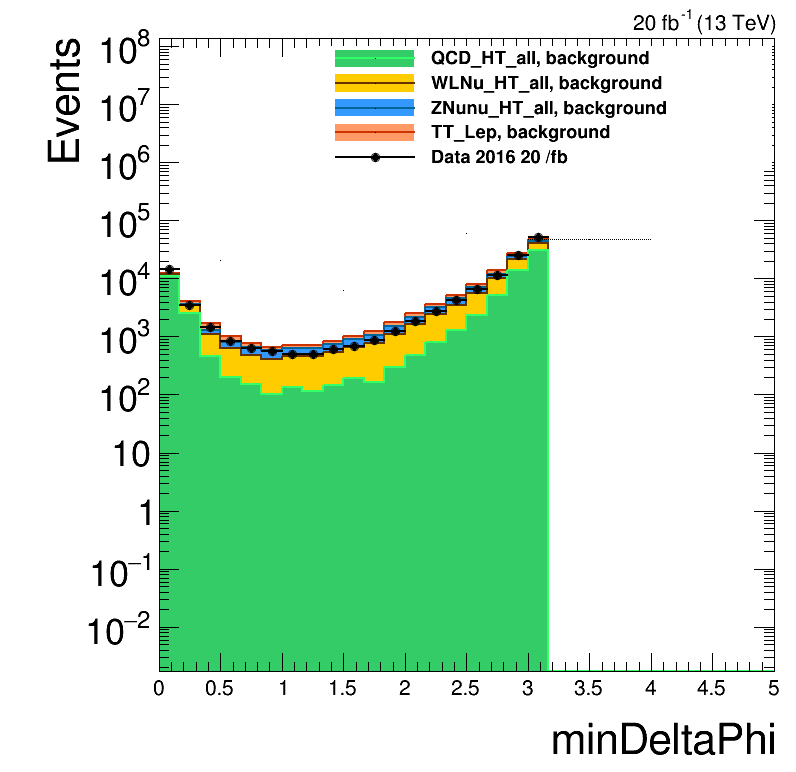

In [12]:
print('PLOTTING')

x_axis = 'minDeltaPhi'
# x_axis = 'MET [GeV]'
y_axis = 'Events'
axis_set = [x_axis, y_axis]
bin_set = [30,0,5]
# bin_set = [30,0,1000]
lumi = 20000 
# lumi = 137000 
part=0
outf = 'mdphi_ht800_stack.png'
# outf = 'met_stack.png'



# Plotting THStack
c = rt.TCanvas('c','c', 800, 800)
ht = {}
# leg = rt.TLegend(0.59,0.70,0.97,0.93)
leg = rt.TLegend(0.40,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
stack = rt.THStack( "hs" , "H Stack " )
total = rt.TH1D('total','total',3,0,3)
color_list = [845,800,861,806,876,597,625]
keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
sig_keys = []
# sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m' ]
data_keys = ['Data 2016']
# sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
bkg_integral = 0.0
max_value = 0
i=0
for k in keys:
    if 'background' in k or True:
        
        
        pt1 = trg_jet_mdphi[k][trg_jet_ht[k]>800] 
        v = pt1 
        w = trg_jet_w[k][trg_jet_ht[k]>800]  
        print(k,len(v))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].Sumw2()
        total.Add(ht[k])
        stack.Add( ht[k])
        ht[k].SetLineColor(color_list[i]+3)
        ht[k].SetFillColor(color_list[i])
        leg.AddEntry(ht[k],k)
        max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
        bkg_integral += ht[k].Integral()
 
        i+=1
stack.Draw('hist')
# stack.SetMaximum(max_value*1.5)
stack.SetMaximum(max_value*1e+03)
stack.SetMinimum(10e-3)
stack.GetYaxis().SetTitle(y_axis)
stack.GetXaxis().SetTitle(x_axis)
stack.GetXaxis().SetLabelSize(0.03)



i=0
for k in sig_keys:
    pt1 = trg_jet_mdphi[k][trg_jet_ht[k]>800]  
    v = pt1 
    w = trg_jet_w[k][trg_jet_ht[k]>800]  
        
    factor = bkg_integral/np.sum(w)
    print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
    ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
    ht[k].Sumw2()
    ht[k].SetLineColor(std_color_list[i])
    print(k, std_color_list[i])
    ht[k].Draw("hist E same")
    leg.AddEntry(ht[k],k)
    max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
    print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

    i+=1
    
i=0
for k in data_keys:
    pt1 = trg_jet_mdphi[k][trg_jet_ht[k]>800]  
    v = pt1 
    w = trg_jet_w[k][trg_jet_ht[k]>800]  
        
    ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
    ht[k].Sumw2()
    ht[k].SetLineColor(std_color_list[i])
    ht[k].SetMarkerColor(std_color_list[i])
    ht[k].SetMarkerStyle(20)
    ht[k].SetMarkerSize(1.)
    print(k, std_color_list[i])
    ht[k].Draw("p E same")
    leg.AddEntry(ht[k],k+' 20 /fb')

    i+=1
    
leg.Draw()

last = stack.GetStack().Last()
total.SetFillStyle(3001)
total.SetLineColor(1)
total.SetFillColor(1)

total.GetYaxis().SetTitleOffset(1.6)
total.Draw("same e2")
print("total",total.GetBinContent(1),total.GetBinError(1))





CMS_lumi.lumi_13TeV = "20 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
c.SaveAs(plotDir+outf)


PLOTTING
QCD_HT_all, background 23172
WLNu_HT_all, background 1403364
ZNunu_HT_all, background 5467455
TT_Lep, background 90989
Data 2016 1
total 0.0 0.0
20 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: QCD_HT_all, background (30, 0.000000, 1000.000000)
Warning in <TROOT::Append>: Replacing existing TH1: WLNu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: 

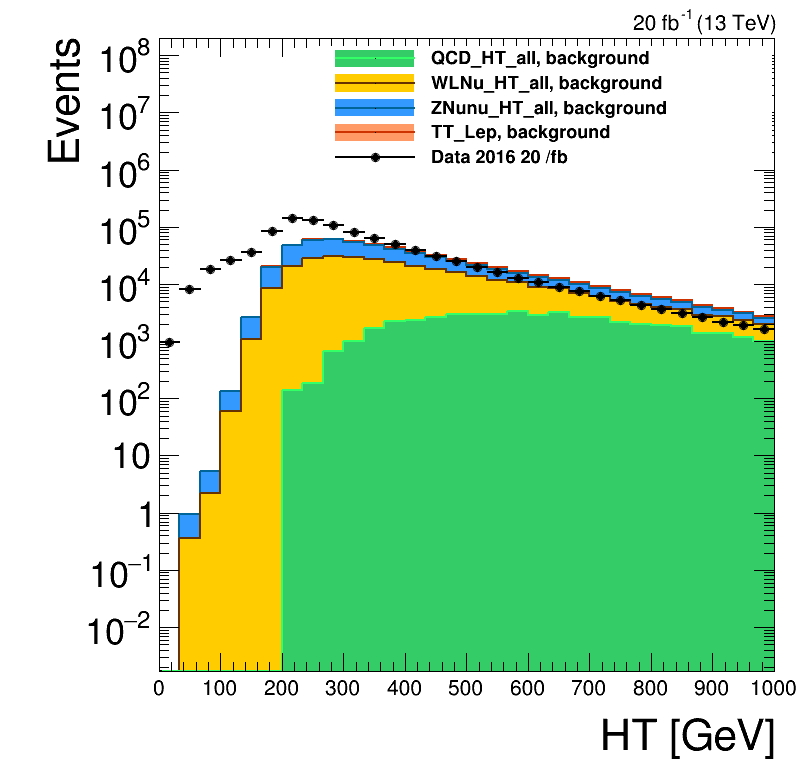

In [19]:
print('PLOTTING')

x_axis = 'HT [GeV]'
# x_axis = 'minDeltaPhi'
# x_axis = 'MET [GeV]'
y_axis = 'Events'
axis_set = [x_axis, y_axis]
# bin_set = [30,0,5]
bin_set = [30,0,1000]
lumi = 20000 
# lumi = 137000 
part=0
outf = 'HT_mdphi0p5_stack.png'
# outf = 'mdphi_ht800_stack.png'
# outf = 'met_stack.png'



# Plotting THStack
c = rt.TCanvas('c','c', 800, 800)
ht = {}
# leg = rt.TLegend(0.59,0.70,0.97,0.93)
leg = rt.TLegend(0.40,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
stack = rt.THStack( "hs" , "H Stack " )
total = rt.TH1D('total','total',3,0,3)
color_list = [845,800,861,806,876,597,625]
keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
sig_keys = []
# sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m' ]
data_keys = ['Data 2016']
# sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
bkg_integral = 0.0
max_value = 0
i=0
for k in keys:
    if 'background' in k or True:
        
        
        pt1 = trg_jet_ht[k][trg_jet_mdphi[k]>0.5] 
        v = pt1 
        w = trg_jet_w[k][trg_jet_mdphi[k]>0.5]  
        print(k,len(v))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].Sumw2()
        total.Add(ht[k])
        stack.Add( ht[k])
        ht[k].SetLineColor(color_list[i]+3)
        ht[k].SetFillColor(color_list[i])
        leg.AddEntry(ht[k],k)
        max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
        bkg_integral += ht[k].Integral()
 
        i+=1
stack.Draw('hist')
# stack.SetMaximum(max_value*1.5)
stack.SetMaximum(max_value*1e+03)
stack.SetMinimum(10e-3)
stack.GetYaxis().SetTitle(y_axis)
stack.GetXaxis().SetTitle(x_axis)
stack.GetXaxis().SetLabelSize(0.03)



i=0
for k in sig_keys:
    pt1 = trg_jet_ht[k][trg_jet_mdphi[k]>0.5] 
    v = pt1 
    w = trg_jet_w[k][trg_jet_mdphi[k]>0.5]  
        
    factor = bkg_integral/np.sum(w)
    print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
    ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
    ht[k].Sumw2()
    ht[k].SetLineColor(std_color_list[i])
    print(k, std_color_list[i])
    ht[k].Draw("hist E same")
    leg.AddEntry(ht[k],k)
    max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
    print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

    i+=1
    
i=0
for k in data_keys:
    pt1 = trg_jet_ht[k][trg_jet_mdphi[k]>0.5] 
    v = pt1 
    w = trg_jet_w[k][trg_jet_mdphi[k]>0.5]  
        
    ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*1)
    ht[k].Sumw2()
    ht[k].SetLineColor(std_color_list[i])
    ht[k].SetMarkerColor(std_color_list[i])
    ht[k].SetMarkerStyle(20)
    ht[k].SetMarkerSize(1.)
    print(k, std_color_list[i])
    ht[k].Draw("p E same")
    leg.AddEntry(ht[k],k+' 20 /fb')

    i+=1
    
leg.Draw()

last = stack.GetStack().Last()
total.SetFillStyle(3001)
total.SetLineColor(1)
total.SetFillColor(1)

total.GetYaxis().SetTitleOffset(1.6)
total.Draw("same e2")
print("total",total.GetBinContent(1),total.GetBinError(1))





CMS_lumi.lumi_13TeV = "20 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
c.SaveAs(plotDir+outf)


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'BDT_Tree' at 0x7f4b6eb8f278>
[610.80817 288.70084 282.1015  218.51424 235.34044 215.80617 773.87085
 325.91827 208.47023 407.9336 ]
QCD_HT_all, background <TTree b'BDT_Tree' at 0x7f4b6eb42cf8>
[253.68602 204.3412  233.23325 209.45142 314.20142 264.73697 272.68582
 204.18715 228.651   373.62445]
WLNu_HT_all, background <TTree b'BDT_Tree' at 0x7f4b6eaef1d0>
[219.44499 212.2948  209.07002 228.07384 204.8972  214.50142 201.22607
 210.68031 218.995   226.65067]
ZNunu_HT_all, background <TTree b'BDT_Tree' at 0x7f4b6eab4630>
[ 209.13554  275.6959   208.11604  408.37134  390.23483 1073.8206
  343.2648   229.78865  245.47514  375.18002]
TT_Lep, background <TTree b'BDT_Tree' at 0x7f4b6eac6390>
[262.6048  210.4145  217.54112 264.47186 243.04875 277.2153  296.05707
 355.52374 223.05655 286.61093]
Data 2016 <TTree b'BDT_Tree' at 0x7f4b5f52e0f0>
[250.41324 219.85379 408.27444 201.22621 265.27634 205.67383 215.23103
 212.79405 215.80478 225.45335]


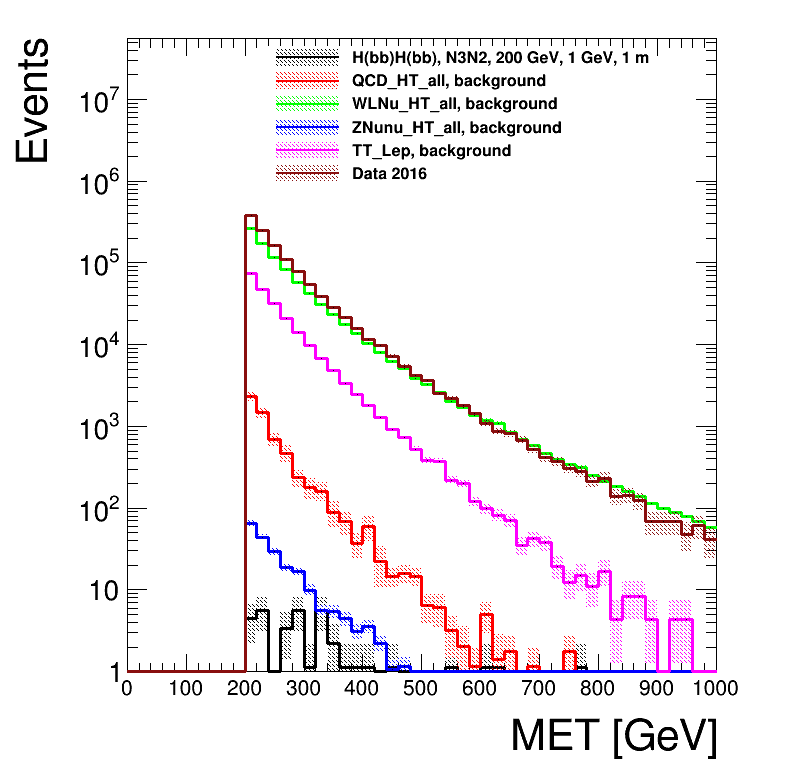

In [8]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}
he = {}


for k,v in tree.items(): 
    print(k,v)

     
    value = trg_jet_met[k]
    print(value[:10])
    
    if 'Data' not in k:
        ws = [x*137000 for x in trg_jet_w[k]]
    else:
        ws = [x*137000/19988 for x in trg_jet_w[k]]

    ht[k] = create_TH1D( value, axis_title=['MET [GeV]', 'Events'], name="", binning=[50,-0,1000], weights=ws)
    

    if i==4:
        i+=1
    if i==6:
        i=204
        
    ht[k].SetLineWidth(3)
    ht[k].SetLineColor(i+1)
    ht[k].SetMarkerColor(i+1)
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+7*(ht[k].GetMaximum()))
    ht[k].SetMinimum(1)
    ht[k].Draw('histsame')
    
    he[k] = create_TH1D( value, axis_title=['MET [GeV]', 'Events'], name="", binning=[50,-0,1000], weights=ws)
    he[k].SetFillColor(i+1)
    he[k].SetLineColor(i+1)
    he[k].SetFillStyle(3018);
    he[k].Draw('e2same')
 

    leg.AddEntry(he[k], k, 'fl')

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(plotDir+'met_1lep.png')

# ht[k] = create_TH1D( value, axis_title=['MET [GeV]', 'Entries'], name="", binning=[50,-0,1000], weights=trg_jet_w[k])
# ht[k].DrawNormalized('Histsame')
